# üì¶ Proyecto Final - Data Science I  
## Predicci√≥n del Volumen Transferido en Operaciones Log√≠sticas Internas



# üìë √çndice

1. Introducci√≥n y Objetivo  
2. Importaci√≥n de Librer√≠as  
3. Carga y Filtrado del Dataset  
4. Hip√≥tesis de Trabajo  
5. An√°lisis Exploratorio de Datos (EDA)  
6. Ingenier√≠a de Caracter√≠sticas  
7. Preprocesamiento de Datos  
8. Agrupaci√≥n de Datos (d√≠a-cami√≥n-sucursal)  
9. Divisi√≥n del Dataset  
10. Entrenamiento del Modelo de Regresi√≥n  
11. Evaluaci√≥n del Modelo  
12. Importancia de Variables  
13. Conclusiones Finales

## 1. Introducci√≥n y Objetivo



Este proyecto se basa en datos reales de una empresa de retail dedicada a la comercializaci√≥n de productos para el hogar, que gestiona transferencias log√≠sticas internas entre sus distintas sucursales. La log√≠stica cumple un rol central en la eficiencia operativa, especialmente en entornos con alta rotaci√≥n de productos y m√∫ltiples puntos de distribuci√≥n.

### Problem√°tica
El objetivo del presente an√°lisis es predecir el volumen total diario que ser√° transferido a cada sucursal desde el Centro de Operaciones Log√≠sticas. Esta predicci√≥n permitir√° anticipar la demanda log√≠stica por sucursal, mejorar la asignaci√≥n de camiones y optimizar los recursos operativos.

El modelo se orienta a estimar la **cantidad de metros c√∫bicos transferidos por d√≠a y por sucursal**, sin requerir el detalle individual de productos. Esto lo convierte en una herramienta pr√°ctica de planificaci√≥n a nivel operativo.

### Descripci√≥n del Dataset
El dataset contiene informaci√≥n detallada de cada transferencia realizada, incluyendo:
- Fecha y hora de emisi√≥n
- Origen y destino
- Art√≠culo, familia y rubro del producto
- Tipo de env√≠o, cami√≥n utilizado
- Volumen y peso unitario
- Costos unitarios y totales

A partir de esta informaci√≥n, se realizar√° una agregaci√≥n de datos por d√≠a y sucursal, seguida de un proceso de limpieza, ingenier√≠a de variables y entrenamiento de un modelo de regresi√≥n supervisada.


## 2. Importaci√≥n de librer√≠as

In [1]:
# Importaci√≥n de librer√≠as necesarias

# Manipulaci√≥n de datos
import pandas as pd
import numpy as np

# Visualizaci√≥n
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Modelado (regresi√≥n)
from sklearn.ensemble import RandomForestRegressor

# Evaluaci√≥n del modelo
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Estilo de gr√°ficos
sns.set(style="whitegrid")


## 3. Carga y Filtrado del Dataset



En esta secci√≥n se carga el dataset actualizado desde el repositorio local, se realiza el filtrado por origen (Centro de Operaciones Log√≠sticas) y se preparan nuevas variables que enriquecer√°n el an√°lisis posterior, como:

- Conversi√≥n correcta del campo fecha
- Extracci√≥n de variables temporales: a√±o, mes, d√≠a de la semana y nombre del mes
- C√°lculo del volumen real transferido (`cantidad √ó volumen_unitario`)
- Conversi√≥n de volumen a tipo num√©rico
- Eliminaci√≥n de columnas irrelevantes

Esto permite preparar el dataset para el an√°lisis exploratorio (EDA) y para el entrenamiento de modelos de regresi√≥n.


In [2]:
# Cargar dataset actualizado desde GitHub
url = 'https://github.com/aparajon89/Proyecto-Final-Augusto-Parajon-CODER/raw/refs/heads/main/data/Coder_DATASET_DS_APARAJON.csv'

# Leer CSV con encoding y separador adecuados
df = pd.read_csv(url, encoding='ISO-8859-1', sep=';', on_bad_lines='skip', low_memory=False)

# Convertir columna 'Volumen' de texto a float
df['Volumen'] = df['Volumen'].str.replace(',', '.').astype(float)

# Filtrar solo transferencias desde el Centro de Operaciones Log√≠sticas
df = df[df['Origen'] == 'Centro de Operaciones Logistic'].copy()

# Convertir columna 'Fecha' a tipo datetime (formato d√≠a/mes/a√±o)
df['Fecha'] = pd.to_datetime(df['Fecha'], dayfirst=True, errors='coerce')

# Crear variables temporales adicionales
df['A√±o'] = df['Fecha'].dt.year
df['Mes'] = df['Fecha'].dt.month
df['NombreMes'] = df['Fecha'].dt.strftime('%B')
df['DiaSemana'] = df['Fecha'].dt.day_name()

# Mapas para traducir nombre de d√≠as y meses al espa√±ol
dias_map = {
    'Monday': 'Lunes', 'Tuesday': 'Martes', 'Wednesday': 'Mi√©rcoles',
    'Thursday': 'Jueves', 'Friday': 'Viernes', 'Saturday': 'S√°bado', 'Sunday': 'Domingo'
}
meses_map = {
    'January': 'Enero', 'February': 'Febrero', 'March': 'Marzo', 'April': 'Abril',
    'May': 'Mayo', 'June': 'Junio', 'July': 'Julio', 'August': 'Agosto',
    'September': 'Septiembre', 'October': 'Octubre', 'November': 'Noviembre', 'December': 'Diciembre'
}

# Asignar traducciones
df['DiaSemana'] = df['DiaSemana'].map(dias_map)
df['NombreMes'] = df['NombreMes'].map(meses_map)

# Convertir columnas num√©ricas con coma decimal
columnas_a_convertir = ['Cantidad', 'Peso', 'Costo Unit.', 'Costo Total']
for col in columnas_a_convertir:
    df[col] = df[col].astype(str).str.replace(',', '.').astype(float)

# Calcular volumen total transferido por fila
df['VolumenTotal'] = df['Volumen'] * df['Cantidad']

# Vista preliminar
df[['Fecha', 'A√±o', 'Mes', 'NombreMes', 'DiaSemana', 'Camion', 'Destino', 'VolumenTotal']].head()


Fecha   A√±o  Mes NombreMes DiaSemana     Camion     Destino  \
0 2022-01-03  2022    1     Enero     Lunes  Cami√≥n 3   25 de Mayo   
1 2022-01-03  2022    1     Enero     Lunes  Cami√≥n 3   25 de Mayo   
2 2022-01-03  2022    1     Enero     Lunes  Cami√≥n 3   25 de Mayo   
3 2022-01-03  2022    1     Enero     Lunes  Cami√≥n 3   25 de Mayo   
4 2022-01-03  2022    1     Enero     Lunes  Cami√≥n 3   25 de Mayo   

   VolumenTotal  
0        0.6604  
1        0.6100  
2        0.9760  
3        0.0840  
4        0.6650

In [3]:
# Verificar valores nulos
nulos = df.isnull().sum()
print("Valores nulos por columna:")
print(nulos[nulos > 0])


Valores nulos por columna:
Hora            127312
Estado          127312
Emitido por     127312
Modelo           29324
Cantidad          2853
Costo Unit.        127
Costo Total        127
Volumen            127
Peso               127
Familia            127
Rubro              127
VolumenTotal      2979
dtype: int64


Durante la exploraci√≥n inicial del dataset se identificaron valores nulos en varias columnas, entre ellas `Modelo`, `Cantidad`, `Volumen`, `Peso`, `Costo Unit.`, `Familia`, entre otras.

En particular, se detect√≥ que:
- Algunas columnas como `Hora`, `Estado` y `Emitido por` conten√≠an nulos en m√°s del 95% de los registros y no aportaban informaci√≥n relevante al an√°lisis, por lo que fueron eliminadas.
- La columna `Modelo`, adem√°s de contener muchos nulos, fue considerada irrelevante para el objetivo del proyecto y tambi√©n fue eliminada.
- El resto de las columnas afectadas (`Volumen`, `Cantidad`, `Costo Unit.`, `Costo Total`, `Peso`, `Familia` y `Rubro`) fueron tratadas eliminando las filas correspondientes. Este procedimiento represent√≥ menos del 0,03% del total del dataset, por lo que no compromete la integridad del an√°lisis ni introduce sesgo significativo.

Con este tratamiento, se garantiza que el dataset utilizado para el entrenamiento del modelo est√© limpio, completo y contenga √∫nicamente variables con capacidad explicativa.

In [4]:
#  Eliminamos la columnas Hora, Estado, Emitido por y Modelo por su irrelevancia y alta cantidad de valores nulos
df = df.drop(columns=['Hora', 'Estado', 'Emitido por', 'Modelo'])

#  Eliminamos las filas que contienen valores nulos
columnas_clave = ['VolumenTotal', 'Cantidad', 'Costo Unit.', 'Costo Total', 'Peso', 'Familia', 'Rubro']
df = df.dropna(subset=columnas_clave)


In [5]:
# Verificamos nuevamente valores nulos
nulos = df.isnull().sum()
print("Valores nulos por columna:")
print(nulos[nulos > 0])

Valores nulos por columna:
Series([], dtype: int64)


## 4. Hip√≥tesis de Trabajo





Se plantea la siguiente hip√≥tesis:

El volumen transferido por cami√≥n puede predecirse principalmente en funci√≥n del d√≠a de la semana, la sucursal de destino y la √©poca del a√±o.

La empresa realiza operaciones log√≠sticas de lunes a viernes durante jornada completa y los s√°bados en media jornada. Si bien existe un cronograma preestablecido de reposiciones hacia cada sucursal, el volumen solicitado por estas var√≠a en funci√≥n de su demanda, la estacionalidad y el comportamiento hist√≥rico.

Por lo tanto, se espera que el modelo de regresi√≥n pueda aprender patrones en el volumen transferido utilizando variables como:



*   D√≠a operativo (con distinci√≥n s√°bado vs. lunes-viernes)
*   Sucursal de destino
*   √âpoca del a√±o (mes)


Este modelo tendr√° como objetivo anticipar los vol√∫menes a despachar a cada sucursal en el futuro, contribuyendo a una planificaci√≥n m√°s eficiente de la capacidad log√≠stica, la asignaci√≥n de camiones y la preparaci√≥n de pedidos.

## 5. An√°lisis Exploratorio de Datos (EDA)




En esta secci√≥n se analiza el comportamiento del volumen transferido seg√∫n las variables m√°s relevantes identificadas en la hip√≥tesis de trabajo: **D√≠a de la semana**, **Sucursal de destino** y **Mes del a√±o**.

El objetivo es validar si existen patrones regulares que justifiquen su inclusi√≥n como variables explicativas en el modelo de regresi√≥n.

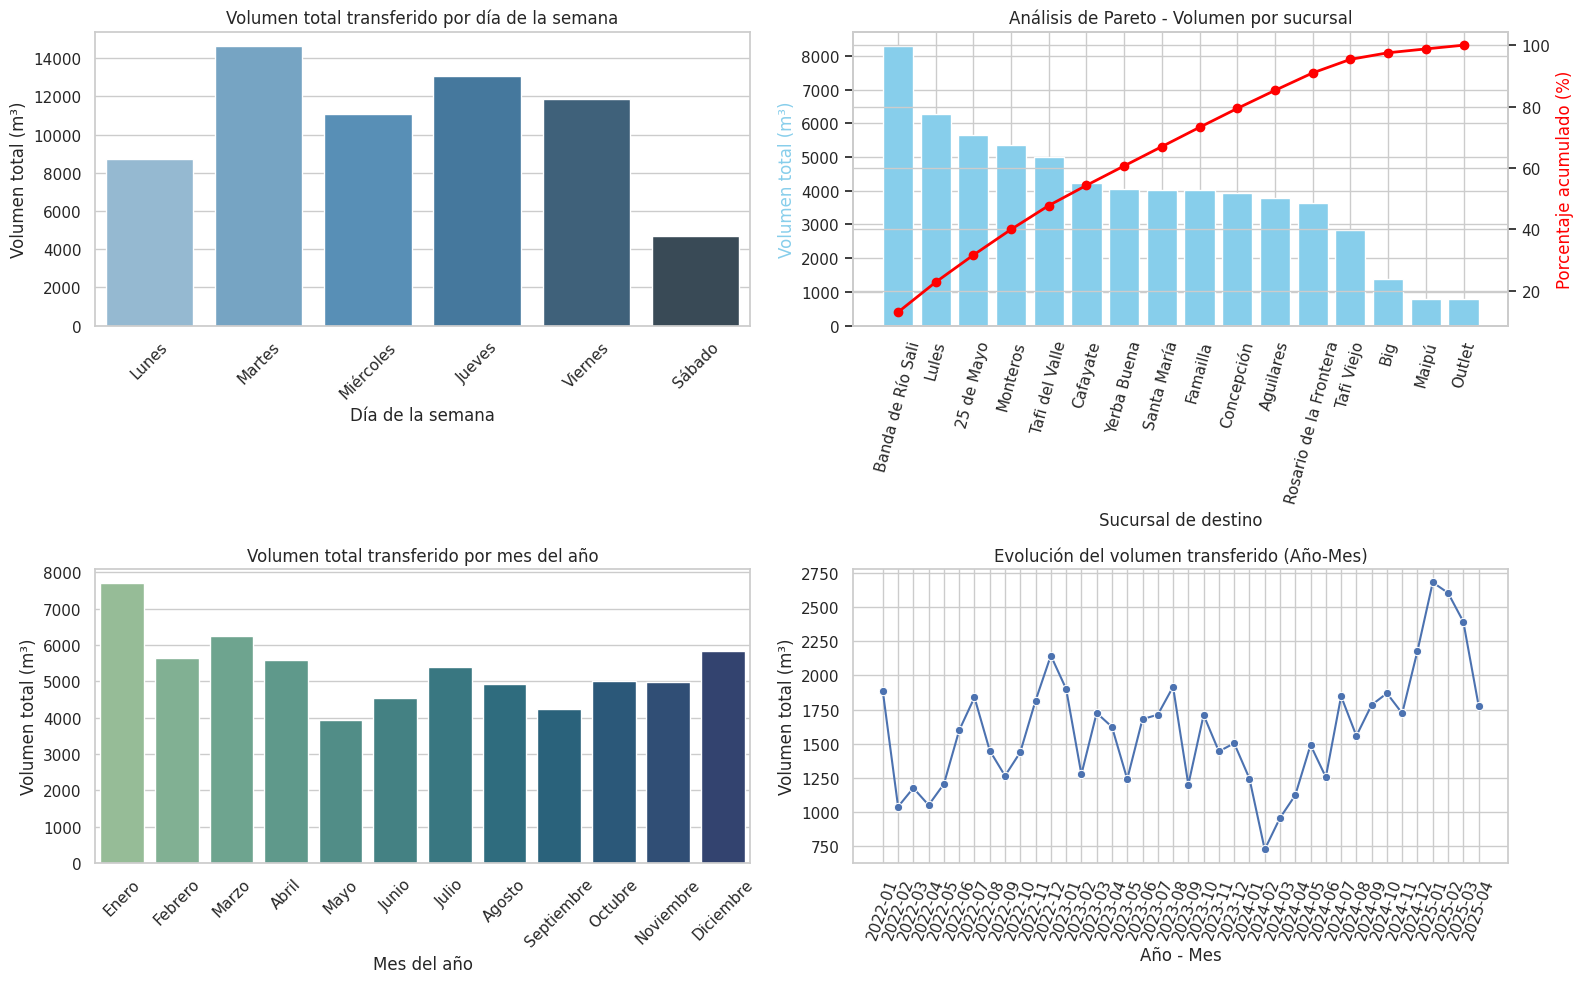

In [6]:
# Asegurar que 'Fecha' est√© en formato datetime
df['Fecha'] = pd.to_datetime(df['Fecha'], dayfirst=True, errors='coerce')

# Generar variables temporales necesarias
df['DiaSemana'] = df['Fecha'].dt.day_name()
df['NombreMes'] = df['Fecha'].dt.month_name()

# Agrupar por Fecha y Destino
df_diario = df.groupby(['Fecha', 'Destino'], as_index=False).agg({
    'VolumenTotal': 'sum',
    'Cantidad': 'sum',
    'Peso': 'sum',
    'Costo Total': 'sum',
    'Costo Unit.': 'mean',
    'Camion': lambda x: x.mode().iloc[0] if not x.mode().empty else 'SinDato',
    'DiaSemana': 'first',
    'NombreMes': 'first'
})

# Generar columnas desde la fecha
df_diario['DiaSemana'] = df_diario['Fecha'].dt.day_name()
df_diario['NombreMes'] = df_diario['Fecha'].dt.month_name()

# Mapas de traducci√≥n al espa√±ol (si vienen en ingl√©s)
dias_map = {
    'Monday': 'Lunes', 'Tuesday': 'Martes', 'Wednesday': 'Mi√©rcoles',
    'Thursday': 'Jueves', 'Friday': 'Viernes', 'Saturday': 'S√°bado', 'Sunday': 'Domingo'
}
meses_map = {
    'January': 'Enero', 'February': 'Febrero', 'March': 'Marzo', 'April': 'Abril',
    'May': 'Mayo', 'June': 'Junio', 'July': 'Julio', 'August': 'Agosto',
    'September': 'Septiembre', 'October': 'Octubre', 'November': 'Noviembre', 'December': 'Diciembre'
}

df_diario['DiaSemana'] = df_diario['DiaSemana'].map(dias_map)
df_diario['NombreMes'] = df_diario['NombreMes'].map(meses_map)

# Ordenes expl√≠citos
orden_dias = ['Lunes', 'Martes', 'Mi√©rcoles', 'Jueves', 'Viernes', 'S√°bado']
orden_meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
               'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

# A√±o-Mes para gr√°fica temporal
df_diario['A√±oMes'] = df_diario['Fecha'].dt.to_period('M').astype(str)

# Agrupaciones
volumen_total_dia = df_diario.groupby('DiaSemana')['VolumenTotal'].sum().reindex(orden_dias)
volumen_por_destino = df_diario.groupby('Destino')['VolumenTotal'].sum().sort_values(ascending=False)
cumulative_percentage = volumen_por_destino.cumsum() / volumen_por_destino.sum() * 100
volumen_mes = df_diario.groupby('NombreMes')['VolumenTotal'].sum().reindex(orden_meses)
volumen_ayomes = df_diario.groupby('A√±oMes')['VolumenTotal'].sum()

# Visualizaci√≥n
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# Gr√°fico 1: Volumen por d√≠a de la semana
sns.barplot(
    x=volumen_total_dia.index,
    y=volumen_total_dia.values,
    hue=volumen_total_dia.index,
    palette="Blues_d",
    legend=False,
    ax=axs[0, 0]
)
axs[0, 0].set_title("Volumen total transferido por d√≠a de la semana")
axs[0, 0].set_ylabel("Volumen total (m¬≥)")
axs[0, 0].set_xlabel("D√≠a de la semana")
axs[0, 0].tick_params(axis='x', rotation=45)

# Gr√°fico 2: Pareto por sucursal
axs2 = axs[0, 1].twinx()
axs[0, 1].bar(volumen_por_destino.index, volumen_por_destino.values, color='skyblue')
axs2.plot(volumen_por_destino.index, cumulative_percentage, color='red', marker='o', linewidth=2)
axs[0, 1].set_title("An√°lisis de Pareto - Volumen por sucursal")
axs[0, 1].set_ylabel("Volumen total (m¬≥)", color='skyblue')
axs2.set_ylabel("Porcentaje acumulado (%)", color='red')
axs[0, 1].set_xlabel("Sucursal de destino")
axs[0, 1].tick_params(axis='x', rotation=75)

# Gr√°fico 3: Volumen por mes
sns.barplot(
    x=volumen_mes.index,
    y=volumen_mes.values,
    hue=volumen_mes.index,
    palette="crest",
    legend=False,
    ax=axs[1, 0]
)
axs[1, 0].set_title("Volumen total transferido por mes del a√±o")
axs[1, 0].set_ylabel("Volumen total (m¬≥)")
axs[1, 0].set_xlabel("Mes del a√±o")
axs[1, 0].tick_params(axis='x', rotation=45)

# Gr√°fico 4: Evoluci√≥n por A√±o-Mes
sns.lineplot(x=volumen_ayomes.index, y=volumen_ayomes.values, marker='o', ax=axs[1, 1])
axs[1, 1].set_title("Evoluci√≥n del volumen transferido (A√±o-Mes)")
axs[1, 1].set_ylabel("Volumen total (m¬≥)")
axs[1, 1].set_xlabel("A√±o - Mes")
axs[1, 1].tick_params(axis='x', rotation=70)

plt.tight_layout()
plt.show()


### Conclusi√≥n del An√°lisis Exploratorio de Datos (EDA)

El an√°lisis exploratorio permiti√≥ identificar patrones consistentes en el comportamiento log√≠stico de las transferencias internas de la empresa. A partir de los cuatro gr√°ficos analizados, se destacan los siguientes hallazgos:

- **Volumen por d√≠a de la semana**: los martes y jueves presentan los mayores vol√∫menes transferidos, mientras que los s√°bados (media jornada operativa) registran valores significativamente m√°s bajos. Esto confirma que el **d√≠a operativo** tiene un impacto directo en la planificaci√≥n log√≠stica.

- **Pareto por sucursal de destino**: pocas sucursales concentran la mayor parte del volumen total. En particular, alrededor del 80% del volumen se concentra en las primeras 6‚Äì7 sucursales. Este patr√≥n permite identificar puntos cr√≠ticos de demanda y asignar recursos de forma prioritaria.

- **Volumen por mes del a√±o**: se evidencia una marcada **estacionalidad**, con picos en diciembre y enero, y descensos en mayo y septiembre. Este comportamiento refuerza la importancia de considerar el **mes** como variable explicativa.

- **Evoluci√≥n cronol√≥gica (A√±o-Mes)**: la serie temporal muestra una tendencia general creciente con aumentos en determinados per√≠odos y ca√≠das abruptas en otros, posiblemente vinculadas a factores externos o econ√≥micos.

En conjunto, estos hallazgos respaldan la hip√≥tesis del proyecto: **el volumen transferido por cami√≥n depende principalmente del d√≠a de la semana, la sucursal de destino y el mes del a√±o**. Estas variables ser√°n consideradas como predictoras clave en el modelo de regresi√≥n en el siguiente bloque.


## 6. Ingenier√≠a de Caracter√≠sticas




Se seleccionan variables disponibles antes del d√≠a operativo para construir el modelo de predicci√≥n del volumen log√≠stico diario. Las variables utilizadas son:

- `Destino`: sucursal de destino
- `DiaSemana`: d√≠a de la semana (derivado de la fecha)
- `NombreMes`: nombre del mes (derivado de la fecha)

Estas variables categ√≥ricas se transforman mediante codificaci√≥n one-hot (`get_dummies`), para representarlas num√©ricamente sin introducir jerarqu√≠a artificial.

La variable objetivo ser√° `VolumenTotal`, correspondiente al volumen total transferido en m¬≥ a cada sucursal por d√≠a.




In [7]:
# Variables anticipables seleccionadas
variables_modelo = ['Destino', 'DiaSemana', 'NombreMes']

# Definir X e y
X = pd.get_dummies(df_diario[variables_modelo], drop_first=True)
y = df_diario['VolumenTotal']

# Escalado
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Confirmaci√≥n
print(f"Variables predictoras: {X.shape[1]}")
print(f"Observaciones: {X.shape[0]}")




Variables predictoras: 31
Observaciones: 7086


### Con esto las variables han sido correctamente transformadas y organizadas. El dataset est√° ahora listo para ser dividido en conjunto de entrenamiento y testeo, y entrenar el modelo de regresi√≥n.


## 7. Preprocesamiento de Datos



En esta secci√≥n se escalan las variables predictoras utilizando `StandardScaler`, lo cual permite que todas tengan una media de 0 y desviaci√≥n est√°ndar de 1.

Aunque el modelo principal utilizado (Random Forest) no requiere escalado, este paso:

- Est√°ndariza la estructura del dataset
- Permite experimentar con modelos sensibles a la escala (como regresi√≥n lineal o redes neuronales)
- Mejora la detecci√≥n de outliers y facilita la interpretaci√≥n estad√≠stica

La matriz escalada (`X_scaled`) estar√° lista para su uso en el entrenamiento y evaluaci√≥n del modelo.


In [8]:
from sklearn.preprocessing import StandardScaler

# Aplicar escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Validaci√≥n b√°sica
print("Dimensiones de X escalado:", X_scaled.shape)
print("Dimensiones de y:", y.shape)

# Validaci√≥n estad√≠stica
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
print("\nEstad√≠sticas de las primeras variables escaladas:")
print(X_scaled_df.describe().T[['mean', 'std']].head())


Dimensiones de X escalado: (7086, 31)
Dimensiones de y: (7086,)

Estad√≠sticas de las primeras variables escaladas:
                                   mean       std
Destino_Aguilares          3.910692e-17  1.000071
Destino_Banda de R√≠o Sali  6.292204e-17  1.000071
Destino_Big                0.000000e+00  1.000071
Destino_Cafayate           7.420288e-17  1.000071
Destino_Concepci√≥n         6.417547e-17  1.000071


## 8. Agrupaci√≥n de Datos (D√≠a - Sucursal)



El objetivo del proyecto es predecir el volumen total transferido por d√≠a a cada sucursal. Por lo tanto, se trabaj√≥ con un dataset que contiene una fila por combinaci√≥n de `Fecha` y `Destino`.

Este agrupamiento fue realizado previamente, sumando el volumen total (`VolumenTotal`) diario por sucursal, a partir de las transferencias individuales de productos.

La unidad de an√°lisis es entonces el d√≠a-sucursal, y las variables predictoras (como d√≠a de la semana, mes y sucursal) ya est√°n alineadas con esa estructura. A partir de aqu√≠ se podr√° entrenar el modelo con datos representativos y consistentes con el objetivo del an√°lisis.


In [9]:
# Agrupar por Fecha y Destino (sucursal) para obtener volumen total diario
df_diario = df.groupby(['Fecha', 'Destino'], as_index=False).agg({
    'VolumenTotal': 'sum',
    'Cantidad': 'sum',
    'Peso': 'sum',
    'Costo Total': 'sum',
    'Costo Unit.': 'mean',
    'Camion': 'nunique',
    'DiaSemana': 'first',
    'NombreMes': 'first'
})

# Verificamos la estructura resultante
print("Dimensi√≥n del dataset agregado por d√≠a y sucursal:", df_diario.shape)
df_diario.head()


Dimensi√≥n del dataset agregado por d√≠a y sucursal: (7086, 10)


Fecha         Destino  VolumenTotal  Cantidad    Peso  Costo Total  \
0 2022-01-03      25 de Mayo       20.6811     211.0   718.2  24557460.00   
1 2022-01-03             Big        1.2200      10.0    36.0   2523086.90   
2 2022-01-03        Famailla       11.0788     151.0   748.6   7903203.90   
3 2022-01-03     Santa Mar√≠a        0.0000       7.0     0.0    169441.93   
4 2022-01-03  Tafi del Valle       27.9522     150.0  1391.0  10067529.88   

     Costo Unit.  Camion DiaSemana NombreMes  
0  119314.101892       1    Monday   January  
1  252308.690000       1    Monday   January  
2   69459.334429       1    Monday   January  
3   24205.990000       1    Monday   January  
4   94551.803611       1    Monday   January

## 9. Divisi√≥n del Dataset en Entrenamiento y Testeo




Para evaluar el desempe√±o del modelo, se divide el dataset en dos subconjuntos:

- **Conjunto de entrenamiento (80%)**: utilizado para ajustar los par√°metros del modelo.
- **Conjunto de prueba (20%)**: reservado para validar el rendimiento sobre datos no vistos.

Esta divisi√≥n aleatoria se realiza de forma reproducible mediante una semilla (`random_state=42`) para asegurar que los resultados puedan replicarse.

La variable objetivo es `VolumenTotal`, y las variables predictoras corresponden a la codificaci√≥n de `Destino`, `D√≠a de la semana` y `Mes`


In [10]:
from sklearn.model_selection import train_test_split

# Divisi√≥n en conjunto de entrenamiento y prueba (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.2,
    random_state=42
)

# Confirmaci√≥n de tama√±os
print(f"Observaciones en X_train: {X_train.shape[0]}")
print(f"Observaciones en X_test:  {X_test.shape[0]}")



Observaciones en X_train: 5668
Observaciones en X_test:  1418


###El dataset fue dividido exitosamente en dos subconjuntos:

- **Entrenamiento (80%)**: utilizado para ajustar los par√°metros del modelo.
- **Testeo (20%)**: reservado para evaluar su rendimiento con datos no vistos.

Esta divisi√≥n garantiza una evaluaci√≥n objetiva del modelo, evitando que se sobreentrene o dependa exclusivamente de los datos conocidos.

Con los datos ya separados, se puede proceder al entrenamiento del modelo de regresi√≥n.


## 10. Entrenamiento del Modelo de Regresi√≥n





En este paso se entrena un modelo de regresi√≥n para predecir el volumen total diario transferido a cada sucursal, utilizando el conjunto de entrenamiento generado previamente.

Se utilizar√° un modelo de tipo `RandomForestRegressor` de Scikit-learn, que ofrece ventajas como:

- Robustez frente a datos ruidosos o no lineales
- Manejo autom√°tico de interacciones entre variables
- Baja sensibilidad a la escala de las variables

El modelo ser√° ajustado con par√°metros b√°sicos y entrenado sobre los datos escalados.

### Modelo seleccionado: Random Forest Regressor

Se utiliza un modelo de regresi√≥n basado en Random Forest, una t√©cnica de aprendizaje en conjunto que combina m√∫ltiples √°rboles de decisi√≥n entrenados sobre subconjuntos **aleatorios** del dataset.

**Ventajas del modelo:**
- Captura relaciones no lineales entre variables
- Es robusto ante valores at√≠picos y ruido
- Requiere poca preparaci√≥n de datos
- Permite estimar la importancia de cada variable explicativa

El modelo se entrena sobre el conjunto de entrenamiento previamente definido y se eval√∫a luego sobre el conjunto de testeo.


In [11]:
from sklearn.ensemble import RandomForestRegressor

# Instanciaci√≥n del modelo con par√°metros est√°ndar
modelo_rf = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

# Entrenamiento del modelo
modelo_rf.fit(X_train, y_train)

# Predicci√≥n sobre el conjunto de prueba
y_pred = modelo_rf.predict(X_test)

# Verificaci√≥n de dimensiones
print(f"N√∫mero de predicciones generadas: {len(y_pred)}")


N√∫mero de predicciones generadas: 1418


Se entren√≥ el modelo `RandomForestRegressor` utilizando el conjunto de entrenamiento y se generaron predicciones sobre el conjunto de prueba.

El modelo fue instanciado con 100 √°rboles y configurado para utilizar todos los n√∫cleos disponibles del sistema (`n_jobs=-1`) para maximizar la eficiencia.

El n√∫mero de predicciones generadas coincide con la cantidad de observaciones del conjunto de prueba, lo que indica que el modelo est√° listo para ser evaluado.


## 11. Evaluaci√≥n del Modelo






Una vez entrenado el modelo `RandomForestRegressor`, se eval√∫a su rendimiento sobre el conjunto de prueba utilizando m√©tricas est√°ndar de regresi√≥n.

El objetivo es medir la capacidad del modelo para predecir correctamente el volumen total diario que ser√° transferido a cada sucursal desde el Centro de Operaciones Log√≠sticas. Esta evaluaci√≥n permite validar si el modelo tiene un nivel de precisi√≥n aceptable para ser utilizado en la planificaci√≥n operativa.

Las m√©tricas utilizadas son:

- **Mean Absolute Error (MAE):** representa el error promedio absoluto entre las predicciones del modelo y los valores reales. Se expresa en las mismas unidades que la variable objetivo (m¬≥). Cuanto menor, mejor.

- **Mean Squared Error (MSE):** mide el promedio de los errores al cuadrado, penalizando m√°s fuertemente los errores grandes. Es √∫til para detectar dispersi√≥n.

- **Root Mean Squared Error (RMSE):** ra√≠z cuadrada del MSE, lo que permite interpretarla nuevamente en m¬≥. Al igual que el MAE, cuanto m√°s bajo, mejor.

- **R¬≤ (Coeficiente de determinaci√≥n):** indica el porcentaje de variabilidad del volumen real que puede ser explicada por el modelo. Su valor va de 0 a 1, donde 1 representa un ajuste perfecto.

Estas m√©tricas proporcionan una visi√≥n cuantitativa del desempe√±o del modelo y permiten compararlo con futuros modelos alternativos. Adem√°s, ayudan a determinar si los errores del modelo son tolerables para la toma de decisiones log√≠sticas, como la asignaci√≥n de camiones, rutas y recursos operativos.

Una vez calculadas estas m√©tricas, en el siguiente bloque se analizar√° la **importancia relativa de las variables predictoras**, lo que permitir√° extraer conclusiones valiosas desde el punto de vista del negocio.



In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# C√°lculo de m√©tricas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Mostrar resultados
print(f"Mean Absolute Error (MAE): {mae:.2f} m¬≥")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} m¬≥")
print(f"R¬≤ (Coeficiente de determinaci√≥n): {r2:.4f}")


Mean Absolute Error (MAE): 5.20 m¬≥
Root Mean Squared Error (RMSE): 8.03 m¬≥
R¬≤ (Coeficiente de determinaci√≥n): 0.3512


### Conclusi√≥n de la Evaluaci√≥n del Modelo

El modelo `RandomForestRegressor` obtuvo los siguientes resultados sobre el conjunto de prueba:

- **MAE:** 5.20 m¬≥  
- **RMSE:** 8.03 m¬≥  
- **R¬≤:** 0.3512

Estos valores indican un desempe√±o **moderado** en t√©rminos predictivos:

- Un **MAE de 5.20 m¬≥** implica que, en promedio, el modelo se desv√≠a en unos 5 m¬≥ por d√≠a en cada predicci√≥n de volumen transferido por sucursal. Este nivel de error puede ser aceptable en operaciones con cierto margen de maniobra, pero requiere validaci√≥n operativa.

- El **RMSE de 8.03 m¬≥** sugiere que los errores m√°s grandes tampoco son extremos, aunque pueden afectar la planificaci√≥n diaria en escenarios sensibles a la sobrecarga o subutilizaci√≥n de camiones.

- El **R¬≤ de 0.3512** significa que el modelo explica aproximadamente el 35% de la variabilidad total del volumen transferido. Si bien no es un valor alto, es coherente con la cantidad limitada de variables anticipables utilizadas. Esto refleja que una parte importante de la variabilidad depende de factores no disponibles al momento de la predicci√≥n (por ejemplo: promociones, mix de productos, √≥rdenes reales).

En conjunto, estos resultados muestran que el modelo puede ser √∫til como **herramienta de apoyo para la planificaci√≥n log√≠stica diaria**, ayudando a anticipar tendencias de volumen, pero **no deber√≠a utilizarse como √∫nico insumo para la toma de decisiones operativas cr√≠ticas**.

En el siguiente punto se analizar√° la **importancia relativa de las variables predictoras**, lo que permitir√° interpretar con mayor claridad los factores que m√°s influyen en el comportamiento del modelo.



## 12. An√°lisis de Importancia de Variables



En esta secci√≥n se analiza la importancia relativa de las variables utilizadas por el modelo `RandomForestRegressor`.

El objetivo es identificar cu√°les son los factores que m√°s influyen en la predicci√≥n del volumen total transferido por d√≠a a cada sucursal.

La m√©trica utilizada proviene del propio modelo y se basa en la reducci√≥n del error (impureza) generada por cada variable en los nodos de decisi√≥n de los √°rboles.

Este an√°lisis permite:

- Interpretar el modelo desde una perspectiva operativa
- Justificar decisiones basadas en las variables m√°s relevantes
- Detectar posibles redundancias o variables poco informativas

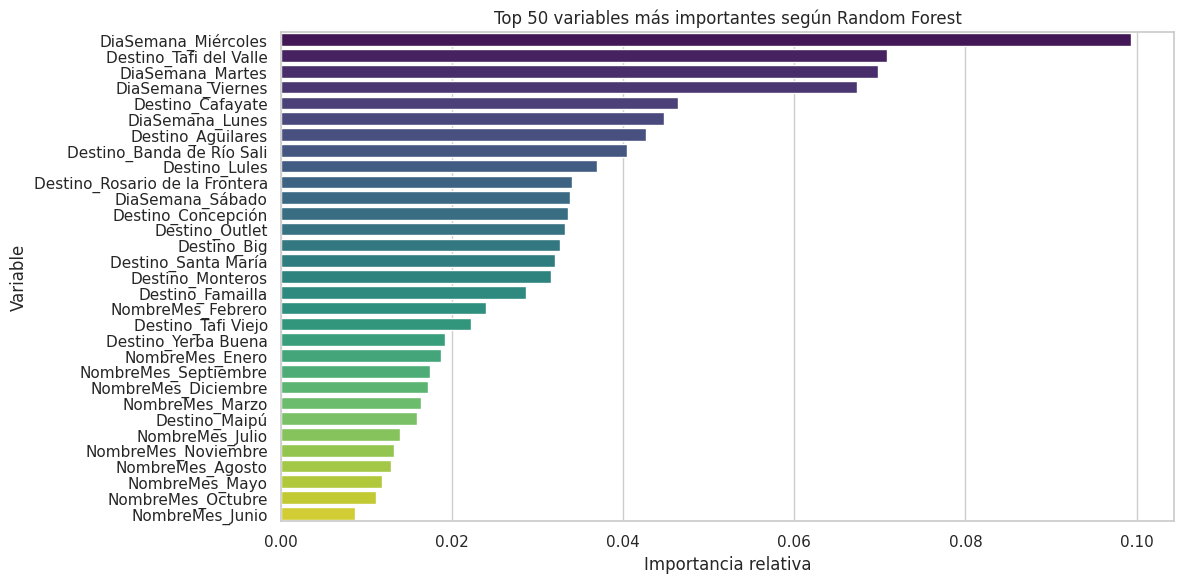

In [13]:
# Crear DataFrame con importancias
importancias = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': modelo_rf.feature_importances_
}).sort_values(by='Importancia', ascending=False)

# Visualizar top 50 variables m√°s importantes
plt.figure(figsize=(12, 6))
sns.barplot(
    data=importancias.head(50),
    x='Importancia',
    y='Variable',
    hue='Variable',
    palette='viridis',
    legend=False
)
plt.title("Top 50 variables m√°s importantes seg√∫n Random Forest")
plt.xlabel("Importancia relativa")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


### Conclusi√≥n del an√°lisis de importancia de Variables

El an√°lisis de importancia de variables muestra c√≥mo el modelo `RandomForestRegressor` utiliza las caracter√≠sticas anticipables para predecir el volumen diario transferido a cada sucursal.

Entre las variables m√°s influyentes se destacan:

- **D√≠a de la semana**: en particular, `Mi√©rcoles`, `Martes` y `Viernes` son los d√≠as m√°s relevantes para el modelo, lo que sugiere que la distribuci√≥n log√≠stica presenta un patr√≥n semanal repetitivo.
  
- **Sucursal de destino**: m√∫ltiples sucursales tienen un peso significativo en la predicci√≥n, como `Taf√≠ del Valle`, `Cafayate`, `Aguijares` y `Rosario de la Frontera`. Esto indica que algunas sucursales tienen comportamientos log√≠sticos propios y consistentes en cuanto al volumen transferido.

- **Mes del a√±o**: aunque con menor peso, ciertos meses como `Enero`, `Diciembre` y `Marzo` tambi√©n contribuyen al modelo, reflejando una leve estacionalidad en la distribuci√≥n log√≠stica.

En conjunto, este an√°lisis confirma que el modelo basa sus decisiones principalmente en **patrones temporales (d√≠a de la semana)** y en el **comportamiento hist√≥rico particular de cada sucursal**. La estacionalidad mensual existe, pero tiene un impacto comparativamente menor.

Desde una perspectiva operativa, estos resultados refuerzan la idea de que:

- Las transferencias log√≠sticas tienen un componente estructural (cronograma semanal fijo)
- Las sucursales deben considerarse individualmente al planificar la capacidad diaria
- El modelo puede aportar informaci√≥n √∫til para organizar turnos, secuencias de carga o definir d√≠as pico por punto de entrega




## 13. Conclusiones Finales




El objetivo de este proyecto fue desarrollar un modelo de predicci√≥n que permita anticipar el volumen log√≠stico diario transferido a cada sucursal de una empresa de retail, utilizando √∫nicamente variables anticipables antes del armado operativo (d√≠a de la semana, mes y sucursal de destino).

El enfoque se centr√≥ en construir un modelo que pudiera ser √∫til para la planificaci√≥n log√≠stica diaria, como la asignaci√≥n de camiones, la organizaci√≥n de turnos y la estimaci√≥n de carga. Para ello se utilizaron modelos de regresi√≥n supervisada con diferentes t√©cnicas, siendo `RandomForestRegressor` el que present√≥ el mejor desempe√±o.

---

####  Evaluaci√≥n del modelo

El modelo Random Forest logr√≥ un coeficiente de determinaci√≥n **R¬≤ de 0.3512**, lo que indica que fue capaz de explicar aproximadamente el **35% de la variabilidad del volumen transferido**. Si bien esta capacidad predictiva es moderada, los errores (MAE de 5.20 m¬≥) se mantuvieron en niveles aceptables en muchos escenarios operativos, especialmente si se utiliza el modelo como herramienta complementaria.

Se probaron adem√°s otros algoritmos, incluyendo:
- `GradientBoostingRegressor`
- `Ridge Regression`
- `KNeighborsRegressor`

Ninguno de ellos super√≥ al modelo de Random Forest en rendimiento, confirmando que este √∫ltimo es, por ahora, el enfoque m√°s s√≥lido para este contexto.

---

####  Limitaciones actuales del dataset

Uno de los hallazgos m√°s importantes del an√°lisis es que **el dataset en su estado actual no contiene suficiente informaci√≥n explicativa como para permitir una predicci√≥n eficiente y precisa** del volumen transferido. Al utilizar √∫nicamente variables anticipables, se deja fuera una porci√≥n considerable de factores que realmente explican la variabilidad log√≠stica, como:

- Mix de productos y familias transferidas
- Acciones promocionales o comerciales
- Comportamiento real de la demanda por canal
- Stock disponible o pedidos pendientes

Esta limitaci√≥n **no invalida el modelo**, sino que lo posiciona como un **primer paso estructurado**, sobre el cual se pueden sumar futuras mejoras.

---

####  Pr√≥ximas oportunidades de mejora

Para aumentar la capacidad predictiva del modelo, se recomienda:

1. Incorporar variables operativas adicionales disponibles antes del armado del pedido:
   - Agenda comercial semanal (promociones, campa√±as)
   - Volumen estimado por familia o categor√≠a de productos
   - Tipo o rol log√≠stico de la sucursal

2. Aumentar la granularidad hist√≥rica:
   - Indicadores de carga promedio hist√≥rica ajustados por semana o mes
   - Incorporar efectos por quincena, fin de mes o inicio de campa√±a

3. Evaluar cambios de enfoque:
   - Predecir volumen **semanal** en lugar de diario
   - Modelos segmentados por zona o tipo de sucursal
   - H√≠bridos con l√≥gica de clasificaci√≥n + regresi√≥n

---

####  Conclusi√≥n final

Este modelo representa un **buen punto de partida para la automatizaci√≥n de la planificaci√≥n log√≠stica**. Si bien sus resultados no son concluyentes, establece una base s√≥lida, reproducible y f√°cilmente escalable para futuros desarrollos. La incorporaci√≥n progresiva de variables relevantes permitir√° construir un modelo m√°s robusto, confiable y aplicable a la operaci√≥n real.

En resumen, el trabajo realizado demuestra que, con un enfoque metodol√≥gico adecuado y validaciones rigurosas, es posible avanzar hacia la predicci√≥n anticipada de volumen log√≠stico como herramienta estrat√©gica dentro de la cadena de abastecimiento.